# Instructions

We've attached a dataset, MNIST.mat, containing a sample of the famous MNIST benchmark on Canvas.

Your report must provide summaries of each method's performance and some additional details of your implementation. Compare the relative strengths and weaknesses of the methods based on both the experimental results and your understanding of the algorithms.

You can load the data with `scipy.io.loadmat`, which will return a Python dictionary containing the test and train data and labels.

The purpose of this assignment is for you to implement the SVM.
You are not allowed to import an SVM from, for instance, `scikit-learn`.
You may, however, use the library `cvxopt.solvers.qp` for the optimization process.

The functions below are from the **PRML book**.

The usage of `sklearn` is prohibited for part (a), (b), and (c).

In [9]:
import numpy as np
from scipy.io import loadmat
from cvxopt import matrix, solvers
from scipy.stats import mode

solvers.options['show_progress'] = False

mnist = loadmat('MNIST.mat')
test_samples = mnist['test_samples']
test_samples_labels = mnist['test_samples_labels'].astype(int).ravel()
train_samples = mnist['train_samples']
train_samples_labels = mnist['train_samples_labels'].astype(int).ravel()


(a) Develop code for training an SVM for binary classification with nonlinear kernels. You'll need to accomodate non-overlapping class distributions. One way to implement this is to maximize (7.32) subject to (7.33) and (7.34). It may be helpful to redefine these as matrix operations. Let ${1}\in\mathbb{R}^{N\times 1}$ be the vector whose entries are all 1's. Let $\mathbf{a}\in\mathbb{R}^{N\times 1}$ have entries $a_i$. Let $\mathbf{T}\in\mathbb{R}^{N\times N}$ be a diagonal matrix with $\mathbf{T}_{ii} = t_i$ on the diagonal. Then we can reformulate the objective to be

\begin{equation*}
\begin{aligned}
& \text{maximize}
& & \tilde{L}(\mathbf{a}) = {1}^{\mathrm{T}}\mathbf{a} - \frac{1}{2} \mathbf{a}^{\mathrm{T}} \mathbf{T}\mathbf{K} \mathbf{T}\mathbf{a} \\
& \text{subject to}
& & {1}^{\mathrm{T}} \mathbf{a} \preceq C \\
& & & {1}^{\mathrm{T}} \mathbf{a} \succeq 0 \\
& & & \mathbf{a}^{\mathrm{T}} \mathbf{t} = 0
\end{aligned}
\end{equation*}

The "$\preceq$" symbol here means element-wise comparison. This formulation is very close to what `cvxopt` expects.

Hint (`cvxopt` expects the following form):

\begin{equation*}
\begin{aligned}
& \text{minimize}
& & \tilde{L}(\mathbf{a}) = \frac{1}{2} \mathbf{a}^{\mathrm{T}} \mathbf{T}\mathbf{K} \mathbf{T}\mathbf{a} - {1}^{\mathrm{T}}\mathbf{a} \\
& \text{subject to}
& & G \mathbf{a} \preceq h \\
& & & {\mathbf{t}}^{\mathrm{T}}\mathbf{a} = 0
\end{aligned}
\end{equation*}

where $G$ is an $N\times N$ identity matrix ontop of $-1$ times an $N\times N$ identity matrix and $h \in\mathbb{R}^{2N}$ where the first $N$ entries are $C$ and the second $N$ enties are $0$.

Then, develop code to predict the $\{-1,+1\}$ class for new data. To use the predictive model (7.13) you need to determine $b$, which can be done with (7.37).

**This part is worth 30 points. Unexecutable code or solving without using convex optimization can only get up to 20%, which is equivalent to 6pts.**

In [ ]:
import numpy as np
import cvxopt
def nonlinear_kernel(X1,X2, d = 2, c = 1):
    """
    Implement a nonlinear kernel function. Function parameters will vary depending on kernel function.

    Parameters
    ----------
    X1: sample vectors
    X2: new vectors
    
    Returns: matrix with shape (X1, X2)
    
    """
    # Return polynomial kernel https://en.wikipedia.org/wiki/Polynomial_kernel
    # This way, the kernel supports both cases o
    X1= np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)

    return (X1 @ X2.T + c)**d



class SVM(object):

    def __init__(self, kernel=nonlinear_kernel, C=1.0):
        """
        Initialize SVM

        Parameters
        ----------
        kernel : callable
          Specifies the kernel type to be used in the algorithm. If none is given,
          ‘rbf’ will be used. If a callable is given it is used to pre-compute 
          the kernel matrix from data matrices; that matrix should be an array 
          of shape (n_samples, n_samples).
        C : float, default=1.0
          Regularization parameter. The strength of the regularization is inversely
          proportional to C. Must be strictly positive. The penalty is a squared l2
          penalty.
        """
        self.kernel = kernel
        self.C = C
        self.b = None 
        self.W = None
        self.trainset = None 
        self.labels = None 
        self.lagrange = None         

    def fit(self, X, y, precomputed_kernel=None):
        """
        Fit the SVM model according to the given training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features) or (n_samples, n_samples)
            Training vectors.
        y : array-like of shape (n_samples,)
            Target values.
        precomputed_kernel : ndarray of shape (n_samples, n_samples), optional
            If provided, this Gram matrix is reused instead of recomputing the
            kernel from X (useful when repeatedly training on the same data).

        Returns
        -------
        self : object
            Fitted estimator.
        """
        # Hint:
        # 1. Define Quadratic Programming (QP) parameters. Given a QP optimization 
        #    problem in standard form, cvxopt is looking for P, q, G, h, A, and b
        #    (https://cvxopt.org/userguide/coneprog.html#quadratic-cone-programs).
        # 2. Construct the QP, invoke solver (use cvxopt.solvers.qp to maximize the Lagrange (7.32))
        # 3. Extract optimal value and solution. cvxopt.solvers.qp(P, q, G, h, A, b)
        # ["x"] are the Lagrange multipliers.
        
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).ravel()
        self.trainset = X
        self.labels = y 

        n_samples = X.shape[0]
        if precomputed_kernel is not None:
            K = np.asarray(precomputed_kernel, dtype=float)
            if K.shape != (n_samples, n_samples):
                raise ValueError("Precomputed kernel shape does not match number of samples")
        else:
            K = self.kernel(X, X)
        
        P = matrix((np.outer(y, y)*K), tc = 'd')
        q = matrix(-np.ones(n_samples))

        G_std = -np.eye(n_samples)
        h_std = np.zeros(n_samples)

        G_slack = np.eye(n_samples)
        h_slack = np.ones(n_samples) * self.C

        G = matrix(np.vstack((G_std, G_slack)))
        h = matrix(np.hstack((h_std, h_slack)))

        A = matrix(y, (1, n_samples), tc='d')
        b = matrix(0.0)


        solution = cvxopt.solvers.qp(P, q, G, h, A, b) 
        ## Your code here
        alphas = np.ravel(solution["x"])   # convert to 1D numpy array
        self.lagrange = alphas



        eps = 1.0e-5
        support_mask = self.lagrange > eps
        bounded_mask = (self.lagrange > eps) & (self.lagrange < self.C - eps)
        support_indices = np.where(support_mask)[0]

        if np.any(bounded_mask):
            bias_terms = []
            for n in np.where(bounded_mask)[0]:
                total = 0.0
                for m in support_indices:
                    total += self.lagrange[m] * y[m] * float(self.kernel(X[n], X[m]))
                bias_terms.append(y[n] - total)
            self.b = float(np.mean(bias_terms))
        else:
            self.b = 0.0   # fallback

        return self

    def predict(self, X):
        """
        Perform classification on samples in X.
                                               
        For an one-class model, +1 or -1 is returned.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features) or (n_samples_test, n_samples_train)

        Returns
        -------
        y_pred : ndarray of shape (n_samples,)
          Class labels for samples in X.
        """
        # Predict by 7.13
        # Your code here

        if self.trainset is None or self.lagrange is None:
            return None
        
        X = np.asarray(X, dtype=float)
        X = np.atleast_2d(X)

        support_indices = np.where(self.lagrange > 1.0e-5)[0]
        if support_indices.size == 0:
            baseline = np.sign(self.b if self.b is not None else 0.0)
            baseline = 1.0 if baseline == 0 else baseline
            return np.full(X.shape[0], baseline, dtype=int)

        support_vectors = self.trainset[support_indices]
        support_lagrange = self.lagrange[support_indices]
        support_labels = self.labels[support_indices]
        bias = self.b if self.b is not None else 0.0

        y_pred = []
        for x in X:
            k_vals = self.kernel(support_vectors, x).reshape(-1)
            decision_value = np.dot(support_lagrange * support_labels, k_vals) + bias
            if np.isclose(decision_value, 0.0):
                y_pred.append(1.0)
            else:
                y_pred.append(np.sign(decision_value))

        return np.array(y_pred, dtype=int)
    

    def score(self, X, y):
        """
        Return the mean accuracy on the given test data and labels. 

        In multi-label classification, this is the subset accuracy which is a harsh 
        metric since you require for each sample that each label set be correctly 
        predicted.
                                                
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
          Test samples.
        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
          True labels for X.

        Return
        ------
        score : float
          Mean accuracy of self.predict(X)
        """
        y = np.asarray(y)
        y_hat = self.predict(X)
        # In case predict returns shape (n,1) somehow, flatten it
        y_hat = y_hat.reshape(-1)
        res = np.sum(y_hat == y) / y.shape[0]
        
        return res

**\<Insert a brief explanation of how your code works in fit() here.\>**

(b) Using your implementation, compare multiclass classification performance of two different voting schemes:

* one versus rest (OVR)
* one versus one (OVO)

**This part is worth 40 points. Unexecutable code or solving without using OVR nor OVO can only get up to 20%, which is equivalent to 8pts.** 

In [ ]:
class OneVsRestClassifier():
    def __init__(self, num_labels, C = 1.0, kernel=nonlinear_kernel):
        '''
            num_labels: number of labels.
            C: regularization parameter for SVM.
            kernel: callable kernel function shared by all SVMs.
        '''
        self.classifiers = [] # a list of classifiers corresponding to labels
        self.C = C
        self.num_labels = num_labels
        self.kernel = kernel
        
    def convert_labels(self, one_label, samples_labels):
        '''
            This function converts ~target_label/target_label to -1/1.
            Args:
            one_label: the target label we want to different with the remaining label.
            samples_labels: the original labels.
        '''
        samples_labels = np.asarray(samples_labels).reshape(-1)
        mask = samples_labels == one_label
        samples_labels[mask] = 1
        samples_labels[~mask] = -1
        return samples_labels
        
    def fit(self, train_samples, train_samples_labels):
        '''
            Fitting function for OVR classifier.
        '''
        self.classifiers = []
        train_samples = np.asarray(train_samples, dtype=float)
        labels = np.asarray(train_samples_labels).reshape(-1)

        print("Computing shared Gram matrix for OVR classifiers...")
        gram_matrix = self.kernel(train_samples, train_samples).astype(float)

        for label in range(self.num_labels):
            new_labels = self.convert_labels(label, labels.copy())
            svm = SVM(kernel=self.kernel, C=self.C)
            print(f"Training OVR classifier {label + 1}/{self.num_labels}")
            svm.fit(train_samples, new_labels, precomputed_kernel=gram_matrix)
            self.classifiers.append(svm)

        
    def predict(self, test_samples):
        '''
            Predict test samples' labels. This function should return labels from 0-9 for each sample.
        '''
        # Insert your code here
        scores = []
        test_samples = np.asarray(test_samples, dtype=float)

        for clf in self.classifiers:
            raw_scores = []
            support_idx = np.where(clf.lagrange > 1e-5)[0]
            bias = clf.b if clf.b is not None else 0.0
            for x in test_samples:
                score = 0.0
                for idx in support_idx:
                    score += clf.lagrange[idx] * clf.labels[idx] * float(clf.kernel(x, clf.trainset[idx]))
                score += bias
                raw_scores.append(score)
            scores.append(raw_scores)

        scores = np.array(scores)
        predictions = np.argmax(scores, axis=0)
        return predictions
        
    def score(self, test_samples, test_samples_labels):
        '''
            Return the accuracy of the OVR classifier.
        '''
        for i in range(self.num_labels):
            test_new_labels = self.convert_labels(i, test_samples_labels.copy())
            print(f"% correct for label {i}: ", self.classifiers[i].score(test_samples, test_new_labels))
        results = self.predict(test_samples)
        res = np.sum(results == test_samples_labels.squeeze())/test_samples.shape[0]
        print("One vs Rest Performance on Test Set:", res)
        
        return res

class OneVsOneClassifier():
    def __init__(self, num_labels, C = 1.0):
        '''
            num_labels: number of labels.
            C: regularization parameter for SVM.
        '''
        self.num_labels = num_labels
        self.classifiers = {} # a dictionary classifier, but not list like in OVR. Who's that pokémon???
        self.C = C

        # Do something here to self.classifiers (Hint: initialize it).
        # Insert your code here
    
    def split_dataset(self, i_label, j_label, train_samples, train_samples_labels):
        '''
            Filter the samples to the target i and j samples only. Remember to assign -1/1 labels as well.
            Args:
                i_label: the mask corresponding to label i.
                j_label: the mask corresponding to label j.
                train_samples: original samples for training.
                tran_samples_labels: original labels for training.
        '''
        # Insert your code here
        labels = np.asarray(train_samples_labels).reshape(-1)
        mask = (labels == i_label) | (labels == j_label)
        X = train_samples[mask]
        y = labels[mask].copy()
        y[y == i_label] = 1
        y[y == j_label] = -1
        return X, y
    
    def fit(self, train_samples, train_samples_labels):
        '''
            Fitting function for OVO classifier.
        '''
        # Insert your code here
        for i in range(self.num_labels):
            for j in range(i+1, self.num_labels):
                X_ij, y_ij = self.split_dataset(i, j, train_samples, train_samples_labels)
                svm = SVM(C=self.C)
                svm.fit(X_ij, y_ij)
                self.classifiers[(i, j)] = svm
        return self
        
    
    def predict(self, test_samples):
        '''
            Predict test samples' labels. This function should return labels from 0-9 for each sample.
        '''
        # Insert your code here
        test_samples = np.asarray(test_samples, dtype=float)
        votes = np.zeros((test_samples.shape[0], self.num_labels))

        for (i, j), clf in self.classifiers.items():
            # Predict using this binary classifier
            pred = clf.predict(test_samples)  # gives -1 or +1

            # Vote:
            votes[pred ==  1, i] += 1   # class i vote
            votes[pred == -1, j] += 1   # class j vote

        # Final predicted label = one with max votes
        return np.argmax(votes, axis=1)
    
    def score(self, test_samples, test_samples_labels):
        '''
            Return the accuracy of the OVR classifier.
        '''
        for i in range(self.num_labels):
            for j in range(i + 1, self.num_labels):
                new_test_samples, new_test_samples_labels = self.split_dataset(i, j, test_samples, test_samples_labels)
                print(f"% correct for sub-dataset {(i, j)}", self.classifiers[(i, j)].score(new_test_samples, new_test_samples_labels))
        results = self.predict(test_samples)
        res = np.sum(results == test_samples_labels.squeeze())/test_samples.shape[0]
        print("One vs One Performance on Test Set:", res)
        return res

In [12]:
# Try wtih OVR
ovr_classifier = OneVsRestClassifier(10)
ovr_classifier.fit(train_samples, train_samples_labels)
ovr_classifier.score(test_samples, test_samples_labels)

Computing shared Gram matrix for OVR classifiers...
Training OVR classifier 1/10


C:\Users\arses\AppData\Local\Temp\ipykernel_32540\382786955.py:125: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  total += self.lagrange[m] * y[m] * float(self.kernel(X[n], X[m]))


Training OVR classifier 2/10
Training OVR classifier 3/10
Training OVR classifier 4/10
Training OVR classifier 5/10
Training OVR classifier 6/10
Training OVR classifier 7/10
Training OVR classifier 8/10
Training OVR classifier 9/10
Training OVR classifier 10/10
% correct for label 0:  0.991
% correct for label 1:  0.998
% correct for label 2:  0.983
% correct for label 3:  0.978
% correct for label 4:  0.986
% correct for label 5:  0.981
% correct for label 6:  0.987
% correct for label 7:  0.982
% correct for label 8:  0.965
% correct for label 9:  0.976


C:\Users\arses\AppData\Local\Temp\ipykernel_32540\868778667.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += clf.lagrange[idx] * clf.labels[idx] * float(clf.kernel(x, clf.trainset[idx]))


One vs Rest Performance on Test Set: 0.929


np.float64(0.929)

In [13]:
# Try with OVO
ovo_classifier = OneVsOneClassifier(10)
ovo_classifier.fit(train_samples, train_samples_labels)
ovo_classifier.score(test_samples, test_samples_labels)

C:\Users\arses\AppData\Local\Temp\ipykernel_32540\382786955.py:125: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  total += self.lagrange[m] * y[m] * float(self.kernel(X[n], X[m]))


% correct for sub-dataset (0, 1) 0.0
% correct for sub-dataset (0, 2) 0.9949748743718593
% correct for sub-dataset (0, 3) 1.0
% correct for sub-dataset (0, 4) 0.9948453608247423
% correct for sub-dataset (0, 5) 0.9831460674157303
% correct for sub-dataset (0, 6) 0.976878612716763
% correct for sub-dataset (0, 7) 0.9945945945945946
% correct for sub-dataset (0, 8) 0.9941860465116279
% correct for sub-dataset (0, 9) 1.0
% correct for sub-dataset (1, 2) 0.9914893617021276
% correct for sub-dataset (1, 3) 0.9957805907172996
% correct for sub-dataset (1, 4) 1.0
% correct for sub-dataset (1, 5) 1.0
% correct for sub-dataset (1, 6) 1.0
% correct for sub-dataset (1, 7) 0.995475113122172
% correct for sub-dataset (1, 8) 0.9903846153846154
% correct for sub-dataset (1, 9) 1.0
% correct for sub-dataset (2, 3) 0.9649122807017544
% correct for sub-dataset (2, 4) 0.9864253393665159
% correct for sub-dataset (2, 5) 0.9902439024390244
% correct for sub-dataset (2, 6) 0.985
% correct for sub-dataset (2

np.float64(0.935)


The OVR class/object creates and trains n (10 in this case) classifiers. It does so by looping over the 10 digits, and for each digit, labels the digit as +1 and the rest as -1. Then from the training set, it trains a svm to classify the digits. In case of OVO, the classifiers are somewhat differnet. It loops over all the possible combination of pairs (45 when n = 10), running SVM  and use  majority voting over their +-1 outcomes. Running the two evaluation cells above, the OVR model on the provided MNIST dataset (with a degree 2 polynomial kernel) reaches 0.929, while the corresponding OVO score is 0.935 before tuning. After hyperparameter tuning through grid search, the OVO score reaches 0.9420 at C = 5.7544

(c) The parameter $C>0$ controls the tradeoff between the size of the margin and the slack variable penalty. It is analogous to the inverse of a regularization coefficient. Include in your report a brief discussion of how you found an appropriate value for OVO classifier. (15pts)

In [14]:
# Hyperparameter tuning for the OVO classifier (part c)

def tune_ovo_hyperparameters(train_X, train_y, test_X, test_y, C_values, subset_per_class=None, random_state=0):
    """
    Train multiple OneVsOneClassifier models with different C values and return
    the best performer along with the full set of results. Optionally samples a
    fixed number of examples per class to speed up experimentation.
    """
    train_X = np.asarray(train_X, dtype=float)
    train_y = np.asarray(train_y).reshape(-1)
    test_X = np.asarray(test_X, dtype=float)
    test_y = np.asarray(test_y).reshape(-1)

    if subset_per_class is not None:
        rng = np.random.default_rng(random_state)
        subset_indices = []
        for label in np.unique(train_y):
            label_idx = np.where(train_y == label)[0]
            if label_idx.size > subset_per_class:
                chosen = rng.choice(label_idx, subset_per_class, replace=False)
            else:
                chosen = label_idx
            subset_indices.append(chosen)
        subset_indices = np.concatenate(subset_indices)
        train_X = train_X[subset_indices]
        train_y = train_y[subset_indices]

    results = []
    best_model = None
    best_accuracy = -np.inf
    best_C_value = None

    for C_val in C_values:
        print(f"\nEvaluating OVO classifier with C={C_val:.4f}")
        candidate = OneVsOneClassifier(num_labels=10, C=C_val)
        candidate.fit(train_X, train_y)
        preds = candidate.predict(test_X)
        accuracy = np.mean(preds == test_y)
        print(f"Validation accuracy: {accuracy:.4f}")
        results.append((C_val, accuracy))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_C_value = C_val
            best_model = candidate

    return best_model, best_C_value, results

# Choose candidate C values on a log scale. Adjust subset_per_class for quicker dry-runs.
subset_for_search = None  # e.g., set to 400 to speed up experimentation
C_grid = np.logspace(-1, 1.2, num=6)

best_model_candidate, best_C_value, ovo_c_results = tune_ovo_hyperparameters(
    train_samples,
    train_samples_labels,
    test_samples,
    test_samples_labels,
    C_grid,
    subset_per_class=subset_for_search,
    random_state=42
)

if best_model_candidate is None or best_C_value is None:
    raise RuntimeError("Hyperparameter tuning did not yield a trained OVO model.")

if subset_for_search is None:
    best_ovo_classifier = best_model_candidate
else:
    best_ovo_classifier = OneVsOneClassifier(num_labels=10, C=float(best_C_value))
    best_ovo_classifier.fit(train_samples, train_samples_labels)

best_ovo_predictions = best_ovo_classifier.predict(test_samples)
best_ovo_accuracy = np.mean(best_ovo_predictions == test_samples_labels)

print("\nHyperparameter tuning summary:")
for C_val, accuracy in ovo_c_results:
    print(f"C={C_val:.4f} -> accuracy={accuracy:.4f}")
print(f"\nSelected C={best_C_value:.4f} with accuracy={best_ovo_accuracy:.4f} after refitting on full data.")



Evaluating OVO classifier with C=0.1000


C:\Users\arses\AppData\Local\Temp\ipykernel_32540\382786955.py:125: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  total += self.lagrange[m] * y[m] * float(self.kernel(X[n], X[m]))


Validation accuracy: 0.8970

Evaluating OVO classifier with C=0.2754
Validation accuracy: 0.9220

Evaluating OVO classifier with C=0.7586
Validation accuracy: 0.9280

Evaluating OVO classifier with C=2.0893
Validation accuracy: 0.9350

Evaluating OVO classifier with C=5.7544
Validation accuracy: 0.9420

Evaluating OVO classifier with C=15.8489
Validation accuracy: 0.9420

Hyperparameter tuning summary:
C=0.1000 -> accuracy=0.8970
C=0.2754 -> accuracy=0.9220
C=0.7586 -> accuracy=0.9280
C=2.0893 -> accuracy=0.9350
C=5.7544 -> accuracy=0.9420
C=15.8489 -> accuracy=0.9420

Selected C=5.7544 with accuracy=0.9420 after refitting on full data.



Found the best C by sweeping a logarithmic grid of C values from 0.1 to 20. While going through different C values, store the classifiers, and keep track of the best model/ accuracy pair as best_ovo_classifier, best_C_value, and best_ovo_accuracy.  

(d) In addition to calculating percent accuracy, generate multiclass [confusion matrices](https://en.wikipedia.org/wiki/confusion_matrix) as part of your analysis. (5pts)

C:\Users\arses\AppData\Local\Temp\ipykernel_32540\868778667.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += clf.lagrange[idx] * clf.labels[idx] * float(clf.kernel(x, clf.trainset[idx]))


OVR accuracy (confusion matrix): 0.9290


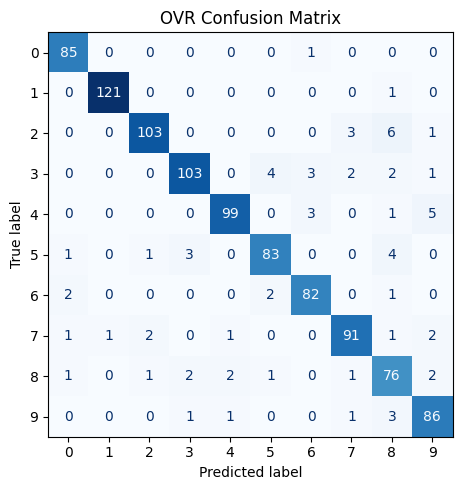

OVO accuracy (confusion matrix): 0.9420


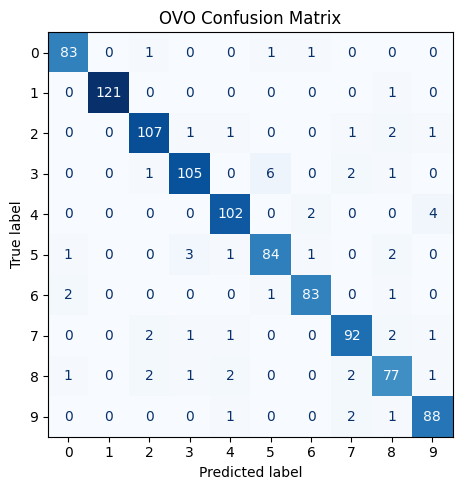

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def plot_confusion(cm, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    plt.tight_layout()
    plt.show()

# Ensure the OVR classifier is trained before generating the matrix
if 'ovr_classifier' not in globals():
    ovr_classifier = OneVsRestClassifier(10)
    ovr_classifier.fit(train_samples, train_samples_labels)

ovr_preds = ovr_classifier.predict(test_samples)
ovr_conf_matrix = confusion_matrix(test_samples_labels, ovr_preds)
ovr_accuracy = np.mean(ovr_preds == test_samples_labels)
print(f"OVR accuracy (confusion matrix): {ovr_accuracy:.4f}")
plot_confusion(ovr_conf_matrix, "OVR Confusion Matrix")

# Prefer the tuned best_ovo_classifier, fall back to the baseline ovo_classifier if needed
if 'best_ovo_classifier' in globals() and best_ovo_classifier is not None:
    ovo_model_for_cm = best_ovo_classifier
elif 'ovo_classifier' in globals():
    ovo_model_for_cm = ovo_classifier
else:
    ovo_model_for_cm = OneVsOneClassifier(10)
    ovo_model_for_cm.fit(train_samples, train_samples_labels)

ovo_preds = ovo_model_for_cm.predict(test_samples)
ovo_conf_matrix = confusion_matrix(test_samples_labels, ovo_preds)
ovo_accuracy = np.mean(ovo_preds == test_samples_labels)
print(f"OVO accuracy (confusion matrix): {ovo_accuracy:.4f}")
plot_confusion(ovo_conf_matrix, "OVO Confusion Matrix")

**\< OVO vs OVR, which one is better?\>**